# Portafolios de Inversión
## Proyecto Final

Presenta :

- Juan Ramón López Rocha

- José Armando Melchor Soto

- Paula Ines Pelayo Morales
---



### Librerías


In [98]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')


---

### Funciones

#### Función Analisis de Acciones

In [99]:
def analizar_accion(ticker_f):
    accion = yf.Ticker(ticker_f)
    # Obtener datos
    info = accion.info
    current_price = info.get('regularMarketPrice', info.get('currentPrice', None))
    book_value_per_share = info.get('bookValue', None)
    trailing_eps = info.get('trailingEps', None)

    # Validar datos
    if None in (current_price, book_value_per_share, trailing_eps):
        return f"Error: No se pudo obtener alguno de los datos para {ticker_f}."

    # Cálculos
    price_to_book = current_price / book_value_per_share if book_value_per_share else None
    price_to_earnings = current_price / trailing_eps if trailing_eps else None

    # Evaluación P/B
    if price_to_book <= 1.2:
        evaluacion_pb = "P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett)."
    elif price_to_book <= 1.6:
        evaluacion_pb = "P/B entre 1.2–1.6: Valuación razonable (rango histórico)."
    else:
        evaluacion_pb = "P/B > 1.6: Posible sobrevaloración."

    # Evaluación P/E
    evaluacion_pe = f"P/E: {price_to_earnings:.2f}. Compara con el S&P 500 (~15–20) para contexto."

    # Resultados
    return (
        f"\nMétricas de {ticker_f}:\n"
        f"Precio Actual: ${current_price:.2f}\n"
        f"EPS (Trailing): ${trailing_eps:.2f}\n"
        f"Price-to-Book (P/B): {price_to_book:.2f}\n"
        f"Price-to-Earnings (P/E): {price_to_earnings:.2f}\n\n"
        f"Evaluación:\n{evaluacion_pb}\n{evaluacion_pe}"
    )


#### Clase Optimizar Pesos

In [100]:
class OptimizePortfolioWeights:

    def __init__(self, returns: pd.DataFrame, risk_free: float):

        self.rets = returns
        self.cov = returns.cov()
        self.rf = risk_free / 252
        self.n_stocks = len(returns.columns)

    # Min Variance
    def opt_min_var(self):


        var = lambda w: w.T @ self.cov @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 1)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=var, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'},
                        tol=1e-16)

        return result.x

    # Sharpe Ratio
    def opt_max_sharpe(self):
        rets = self.rets
        rend, cov, rf = self.rets.mean(), self.cov, self.rf

        sr = lambda w: -((np.dot(rend, w) - rf) / ((w.reshape(-1, 1).T @ cov @ w) ** 0.5))

        result = minimize(sr, np.ones(len(rets.T)), bounds=[(0, None)] * len(rets.T),
                          constraints={'fun': lambda w: sum(w) - 1, 'type': 'eq'},
                          tol=1e-16)

        return result.x

    # Semivariance method
    def opt_min_semivar(self, rets_benchmark):

        rets, corr=self.rets.copy(), self.rets.corr()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        target_downside=np.array(below_zero_target.std())

        target_semivariance=np.multiply(target_downside.reshape(len(target_downside), 1), target_downside) * corr

        semivar = lambda w: w.T @ target_semivariance @ w

        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0, 3)]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=semivar, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x

    # Omega
    def opt_max_omega(self, rets_benchmark):

        rets=self.rets.copy()

        diffs=rets-rets_benchmark.values

        below_zero_target=diffs[diffs<0].fillna(0)
        above_zero_target=diffs[diffs>0].fillna(0)

        target_downside=np.array(below_zero_target.std())
        target_upside=np.array(above_zero_target.std())
        o=target_upside/target_downside

        omega = lambda w: -sum(o * w)


        w0=np.ones(self.n_stocks)/self.n_stocks

        bounds=[(0.05,0.7 )]*self.n_stocks

        constraint=lambda w: sum(w)-1

        result=minimize(fun=omega, x0=w0, bounds=bounds,
                        constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)

        return result.x


#### Clase Dynamic Backtesting

In [101]:
capital = 1000000

In [102]:
class dynamic_backtesting:

    def __init__(self, prices_tactical, prices_strategic, prices_benchmark, capital, rf, months):
        self.prices_tactical = prices_tactical
        self.prices_strategic = prices_strategic
        self.prices_benchmark = prices_benchmark
        self.capital = capital
        self.rf = rf
        self.months = months

    def optimize_weights(self, prices: pd.DataFrame, n_days: int, periods: int):
        start = int(n_days * periods)
        end = int(n_days * (periods + 1))

        temp_data = prices.iloc[start:end, :]
        temp_bench = self.prices_benchmark.iloc[start:end, :]

        temp_rets = temp_data.pct_change().dropna()
        rets_benchmark = temp_bench.pct_change().dropna()

        optimizer = OptimizePortfolioWeights(returns=temp_rets, risk_free=self.rf)

        w_minvar = pd.Series(optimizer.opt_min_var(), index=prices.columns)
        w_sharpe = pd.Series(optimizer.opt_max_sharpe(), index=prices.columns)
        w_semivar = pd.Series(optimizer.opt_min_semivar(rets_benchmark), index=prices.columns)
        w_omega = pd.Series(optimizer.opt_max_omega(rets_benchmark), index=prices.columns)

        return w_minvar, w_sharpe, w_semivar, w_omega

    def simulation(self):
        total_days = len(self.prices_tactical)
        n_periods = round(total_days / 252 * (12 / self.months))
        n_days = round(total_days / n_periods)

        capital = self.capital

        opt_data = self.prices_tactical.iloc[:n_days, :]
        backtesting_tactical = self.prices_tactical.iloc[n_days:, :]
        backtesting_strategic = self.prices_strategic.iloc[n_days:, :]
        backtesting_benchmark = self.prices_benchmark.iloc[n_days:, :]

        rets_tactical = backtesting_tactical.pct_change().dropna()
        rets_strategic = backtesting_strategic.pct_change().dropna()
        rets_benchmark = backtesting_benchmark.pct_change().dropna()

        min_len = min(len(rets_tactical), len(rets_strategic), len(rets_benchmark))
        rets_tactical = rets_tactical.iloc[:min_len, :]
        rets_strategic = rets_strategic.iloc[:min_len, :]
        rets_benchmark = rets_benchmark.iloc[:min_len, :]

        minvar, sharpe, semivar, omega = [capital], [capital], [capital], [capital]
        day_counter, periods_counter = 0, 0

        w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(opt_data, n_days, 0)

        # Pesos estratégicos fijos uniformes
        w_strategic = pd.Series(
            [1 / self.prices_strategic.shape[1]] * self.prices_strategic.shape[1],
            index=self.prices_strategic.columns
        )

        for day in range(min_len - 1):
            if day_counter == n_days:
                w_minvar, w_sharpe, w_semivar, w_omega = self.optimize_weights(backtesting_tactical, n_days, periods_counter)
                periods_counter += 1
                day_counter = 0

            combined_minvar = w_minvar.add(w_strategic, fill_value=0)
            combined_sharpe = w_sharpe.add(w_strategic, fill_value=0)
            combined_semivar = w_semivar.add(w_strategic, fill_value=0)
            combined_omega = w_omega.add(w_strategic, fill_value=0)

            combined_minvar /= combined_minvar.sum()
            combined_sharpe /= combined_sharpe.sum()
            combined_semivar /= combined_semivar.sum()
            combined_omega /= combined_omega.sum()

            rets_combined = pd.concat([
                rets_tactical.iloc[day, :],
                rets_strategic.iloc[day, :]
            ])

            minvar.append(minvar[-1] * (1 + (rets_combined @ combined_minvar)))
            sharpe.append(sharpe[-1] * (1 + (rets_combined @ combined_sharpe)))
            semivar.append(semivar[-1] * (1 + (rets_combined @ combined_semivar)))
            omega.append(omega[-1] * (1 + (rets_combined @ combined_omega)))

            day_counter += 1

        # Capital acumulado benchmark
        capital_benchmark = capital * (1 + rets_benchmark.sum(axis=1)).cumprod()
        capital_benchmark = capital_benchmark.iloc[:len(minvar)-1]  # igual largo

        df = pd.DataFrame({
            'Date': backtesting_tactical.index[:len(minvar)-1],
            'Min Var': minvar[:-1],
            'Sharpe': sharpe[:-1],
            'Semivar': semivar[:-1],
            'Omega': omega[:-1],
            'Benchmark': capital_benchmark.values
        }).set_index('Date')

        return df




#### Función Métricas de Desempeño

In [ ]:
def get_metrics(history, rf):

    # Eliminar columnas completamente NaN
    history_clean = history.dropna(axis=1, how='all')

    # Filtrar columnas con valores no escalares (ej. Series u objetos)
    history_clean = history_clean.loc[:, history_clean.applymap(lambda x: isinstance(x, (int, float, np.float64, np.int64, np.number))).all()]

    # Eliminar columnas con solo un valor único (sin variación)
    history_clean = history_clean.loc[:, history_clean.nunique() > 1]

    # Validar que queden columnas útiles
    if history_clean.empty:
        raise ValueError("El DataFrame de history no tiene columnas válidas para calcular métricas. "
                         "Revisa tus datos o tu simulación.")

    daily_rets = history_clean.pct_change().dropna()
    cov= daily_rets.cov()

    rend_prom = daily_rets.mean() * 252
    std__ = daily_rets.std() * np.sqrt(252)
    RS = (rend_prom - rf) / std__
    downside = daily_rets[daily_rets < 0].fillna(0).std() * np.sqrt(252)
    upside = daily_rets[daily_rets > 0].fillna(0).std() * np.sqrt(252)
    Omega = upside / downside
    Cov_b = cov['Benchmark'] 
    var_b = Cov_b['Benchmark'] 
    Beta = Cov_b / var_b 

    # Alpha Jensen
    R_m = daily_rets['Benchmark'].mean() * 252 
    alpha = rend_prom - (rf + Beta * (R_m - rf))
    # Ratio Treynor
    Treynor = (rend_prom- rf) / Beta
    
    Sortino = (rend_prom - rf) / downside


    metrics = pd.DataFrame(
        [rend_prom, std__, RS, downside, upside ,Omega,Beta,alpha,Treynor, Sortino],
        index=['Rend', 'Vol', 'R Sharpe', 'Downside', 'Upside','Omega','Beta','Alpha de Jensen','R Treynor','R Sortino']
    )


    return metrics

#### Función Gráfica 

In [104]:
def plot_weights_pie(df_percent, strategy_name):
    """
    Grafica un pie chart para la estrategia dada del DataFrame de pesos porcentuales.

    Parámetros:
    - df_percent: DataFrame con los pesos en porcentaje (sumando 100%)
    - strategy_name: string, nombre de la columna a graficar
    """
    if strategy_name not in df_percent.columns:
        print(f"'{strategy_name}' no está en las columnas del DataFrame.")
        return

    palette = sns.color_palette('Greys', len(df_percent.index))

    plt.figure(figsize=(10, 6))
    plt.pie(
        df_percent[strategy_name],
        labels=df_percent.index,
        colors=palette,
        autopct='%.2f%%',
        startangle=90
    )
    plt.title(f'Weights {strategy_name}')
    plt.legend(title='Activos', loc='upper left')
    plt.axis('equal')
    plt.show()

### EJEMPLO
## plot_weights_pie(combined_df_percentage, 'Mínima Varianza')
#plot_weights_pie(combined_df_percentage, 'Máximo Sharpe')


---

### Obtención de Datos

In [105]:
tickers = yf.download(['BRK-B', 'AZO', 'META','NEM','ED','WMT'], start='2024-01-01', end='2025-07-01' ,progress=False,)['Close']
benchmark = yf.download('^GSPC', start='2024-01-01', end='2025-07-01',progress=False)['Close']


In [106]:
ret = tickers.pct_change().dropna()
rets_benchmark = benchmark.pct_change().dropna()

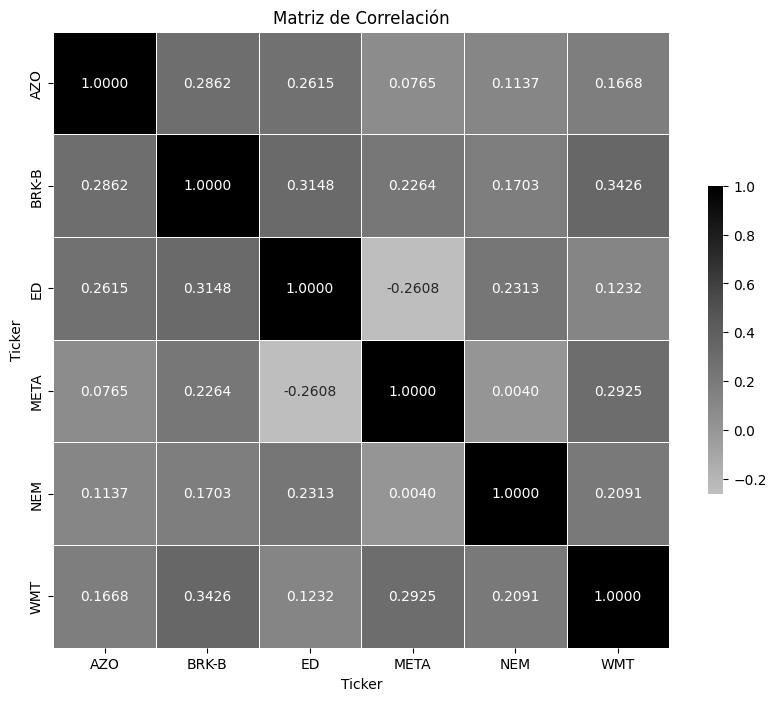

In [107]:
corr = ret.corr()
plt.figure(figsize=(10, 8))  

sns.heatmap(corr, annot=True, fmt=".4f", cmap='Greys', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Matriz de Correlación')
plt.show()

In [108]:
tickers_valuation = ['AZO', 'META','NEM','ED','WMT']
def get_financials(ticker:str) -> pd.DataFrame:
    bs = yf.Ticker(ticker).balance_sheet.iloc[:, :-1]
    ist = yf.Ticker(ticker).income_stmt.iloc[:, :-1]
    cf = yf.Ticker(ticker).cash_flow.iloc[:, :-1]

    return bs, ist, cf

Múltiplos de AZO


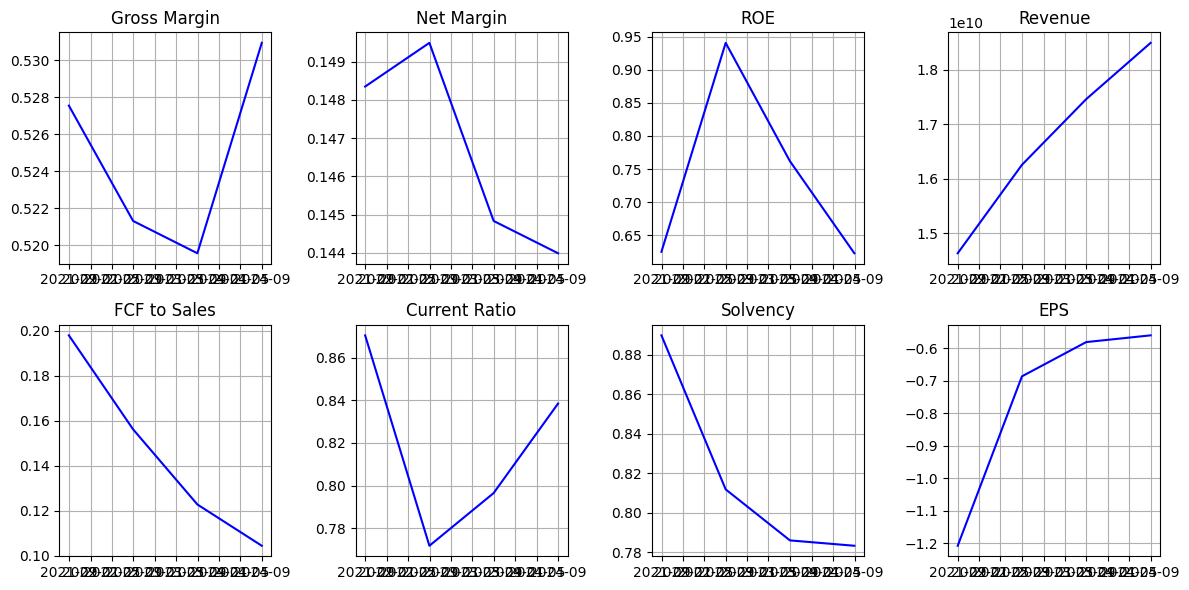

Múltiplos de META


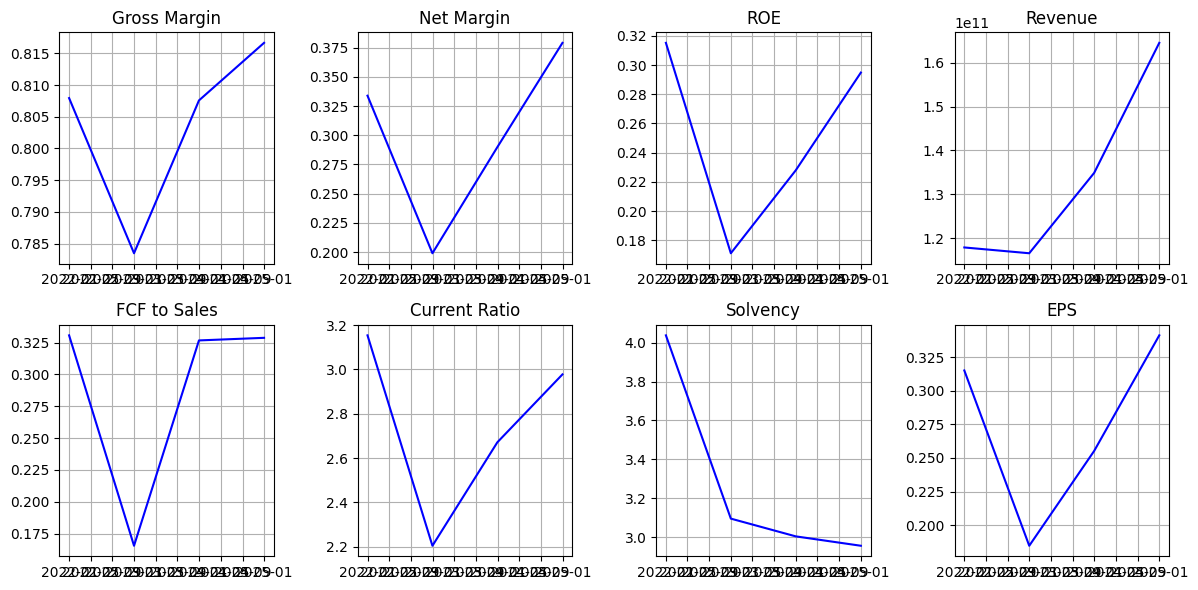

Múltiplos de NEM


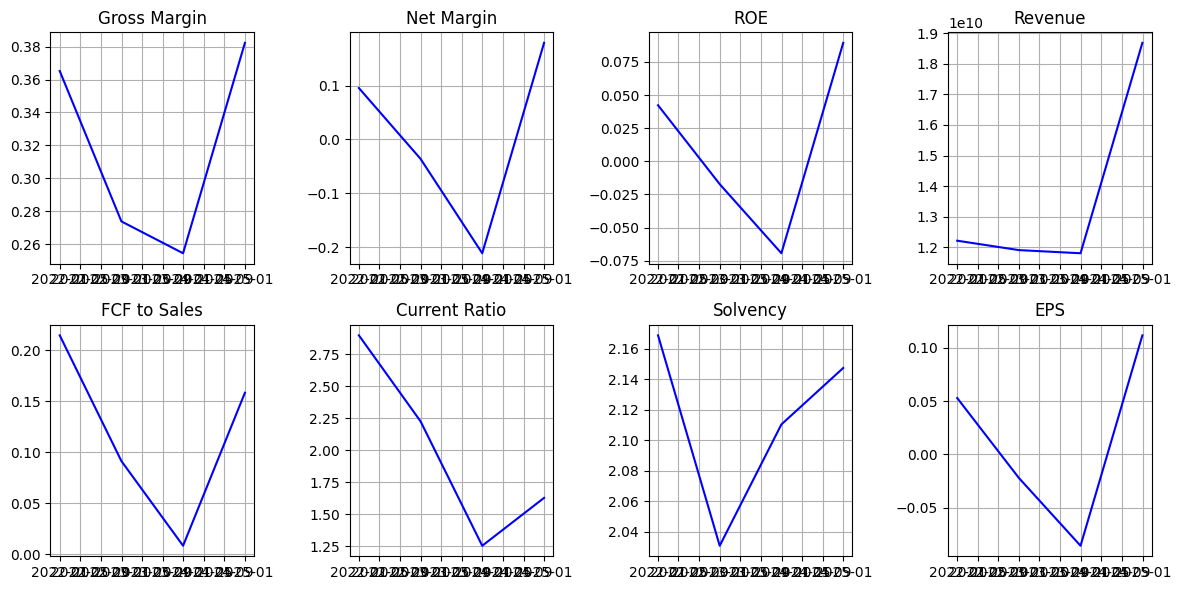

Múltiplos de ED


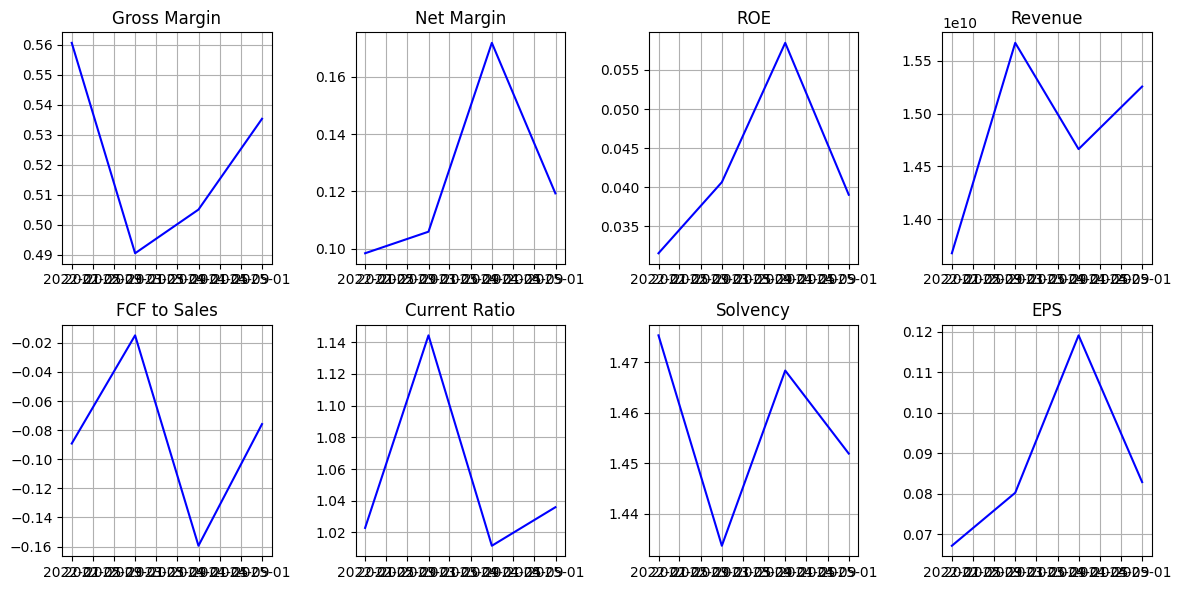

Múltiplos de WMT


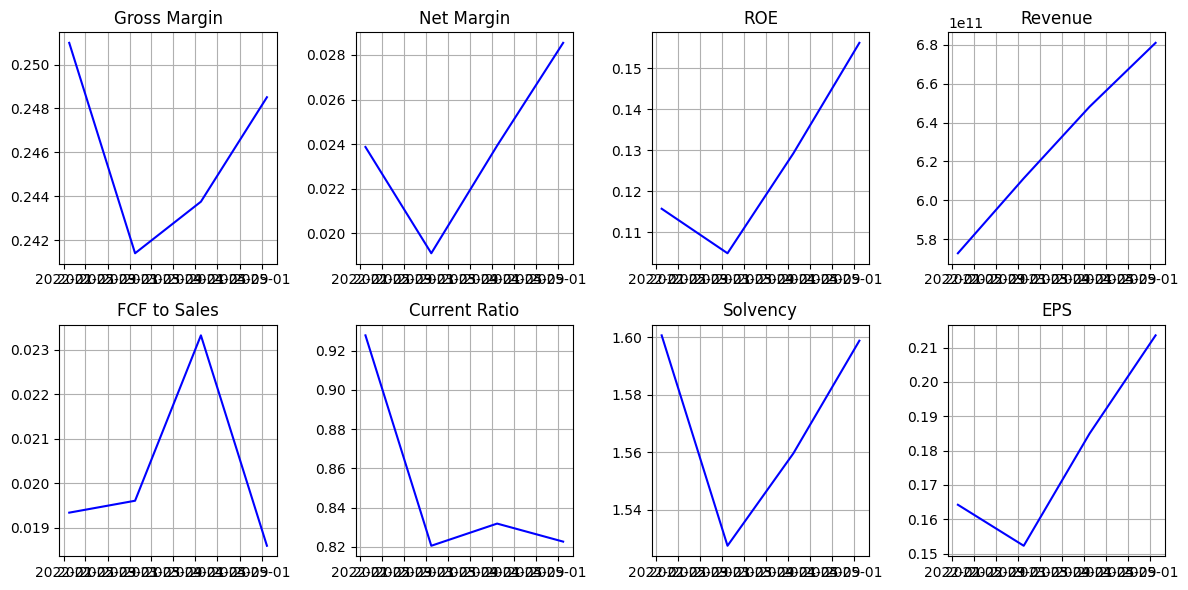

In [109]:
for ticker in tickers_valuation[:5]:

    bs, ist, cf = get_financials(ticker)

    gross_margin = ist.loc['Gross Profit']/ist.loc['Total Revenue']

    net_margin = ist.loc['Net Income Common Stockholders']/ist.loc['Total Revenue']

    roe = ist.loc['Net Income Common Stockholders'] / bs.loc['Total Capitalization']

    revenue = ist.loc['Total Revenue']

    fcf_to_sales = cf.loc['Free Cash Flow'] / ist.loc['Total Revenue']

    current_ratio = bs.loc['Current Assets']/bs.loc['Current Liabilities']

    solvency = bs.loc['Total Assets']/bs.loc['Total Liabilities Net Minority Interest']

    eps = ist.loc['Net Income Common Stockholders'] / bs.loc['Common Stock Equity']

    df_multiplos = pd.DataFrame({
        'Gross Margin': gross_margin,
        'Net Margin': net_margin,
        'ROE': roe,
        'Revenue': revenue,
        'FCF to Sales': fcf_to_sales,
        'Current Ratio': current_ratio,
        'Solvency': solvency,
        'EPS': eps
    })

    df_multiplos.sort_index()

    print(f'Múltiplos de {ticker}')

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    axes = axes.ravel()  # Aplana la matriz de ejes para indexar con un solo número

    for i, column in enumerate(df_multiplos.columns):
        axes[i].plot(df_multiplos.index, df_multiplos.iloc[:, i], c = 'blue')
        axes[i].set_title(column)
        axes[i].grid()
    plt.tight_layout()
    plt.show()

In [110]:
print(analizar_accion("BRK-B"))


Métricas de BRK-B:
Precio Actual: $478.03
EPS (Trailing): $37.53
Price-to-Book (P/B): 0.00
Price-to-Earnings (P/E): 12.74

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 12.74. Compara con el S&P 500 (~15–20) para contexto.


In [111]:
print(analizar_accion("AZO"))


Métricas de AZO:
Precio Actual: $3790.64
EPS (Trailing): $147.46
Price-to-Book (P/B): -15.95
Price-to-Earnings (P/E): 25.71

Evaluación:
P/B ≤ 1.2: Posible infravaloración (umbral de recompra de Buffett).
P/E: 25.71. Compara con el S&P 500 (~15–20) para contexto.


In [112]:
print(analizar_accion("META"))


Métricas de META:
Precio Actual: $718.35
EPS (Trailing): $25.57
Price-to-Book (P/B): 9.80
Price-to-Earnings (P/E): 28.09

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 28.09. Compara con el S&P 500 (~15–20) para contexto.


In [113]:
print(analizar_accion("NEM"))


Métricas de NEM:
Precio Actual: $60.16
EPS (Trailing): $4.39
Price-to-Book (P/B): 2.16
Price-to-Earnings (P/E): 13.70

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 13.70. Compara con el S&P 500 (~15–20) para contexto.


In [114]:
print(analizar_accion("ED"))


Métricas de ED:
Precio Actual: $99.71
EPS (Trailing): $5.41
Price-to-Book (P/B): 1.51
Price-to-Earnings (P/E): 18.43

Evaluación:
P/B entre 1.2–1.6: Valuación razonable (rango histórico).
P/E: 18.43. Compara con el S&P 500 (~15–20) para contexto.


In [115]:
print(analizar_accion("WMT"))


Métricas de WMT:
Precio Actual: $99.35
EPS (Trailing): $2.34
Price-to-Book (P/B): 9.47
Price-to-Earnings (P/E): 42.46

Evaluación:
P/B > 1.6: Posible sobrevaloración.
P/E: 42.46. Compara con el S&P 500 (~15–20) para contexto.


---

## Tactical Asset Allocation

### Optimizar Pesos del Portafolio

In [116]:
optimize_port = OptimizePortfolioWeights(returns=ret, risk_free=0.0445)

#### Optimización Minima Varianza

In [117]:
w_minvar = optimize_port.opt_min_var()*0.5
dict_minvar = dict(zip(ret.columns, w_minvar))
dict_minvar

{'AZO': 0.08421111397422669,
 'BRK-B': 0.1089925364766795,
 'ED': 0.17154503821161135,
 'META': 0.047884591092833564,
 'NEM': 0.012607740332423994,
 'WMT': 0.0747589799122249}

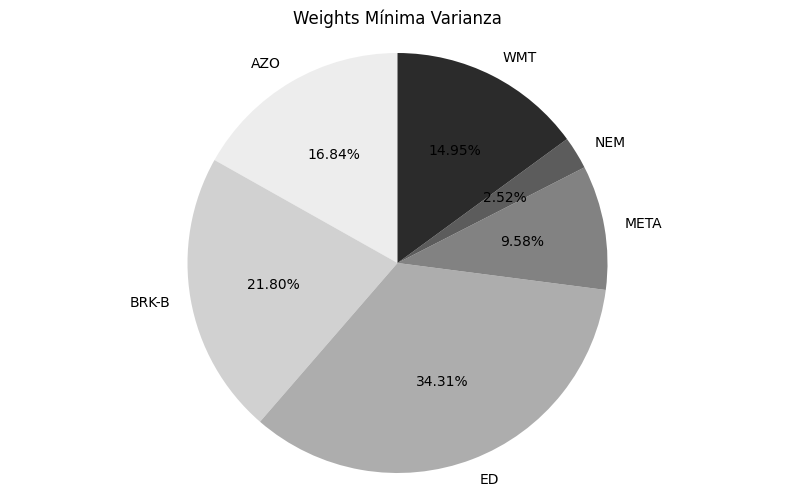

In [118]:
palette = sns.color_palette('Greys', len(w_minvar))

plt.figure(figsize=(10, 6))
plt.pie(
    w_minvar, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Mínima Varianza')
plt.axis('equal')
plt.show()

#### Optimización Máximo de Sharpe

In [119]:
w_maxsharpe = optimize_port.opt_max_sharpe()*0.5
dict_maxsharpe = dict(zip(ret.columns, w_maxsharpe))
dict_maxsharpe

{'AZO': 0.11257971662022204,
 'BRK-B': 5.176295682058303e-19,
 'ED': 0.03370833473474544,
 'META': 0.0946843551143853,
 'NEM': 0.035648857197007784,
 'WMT': 0.22337873633363947}

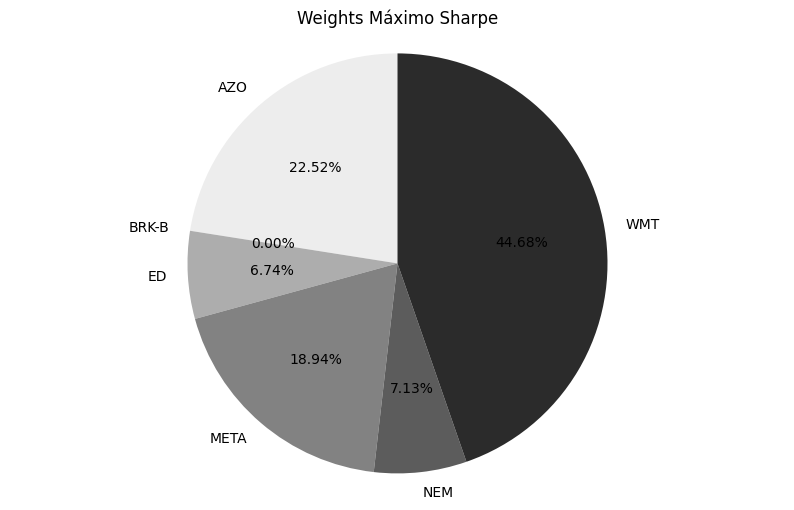

In [120]:
palette = sns.color_palette('Greys', len(w_maxsharpe))

plt.figure(figsize=(10, 6))
plt.pie(
    w_maxsharpe, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Máximo Sharpe')
plt.axis('equal')
plt.show()

#### Optimización Semi Varianza Target

In [121]:
w_semivar = optimize_port.opt_min_semivar(rets_benchmark)*0.5
dict_semivar = dict(zip(ret.columns, w_semivar))
dict_semivar

{'AZO': 0.055979132662612584,
 'BRK-B': 0.17345733496215734,
 'ED': 0.07068427892757033,
 'META': 0.09053946478808012,
 'NEM': 0.013130243101166283,
 'WMT': 0.09620954555841331}

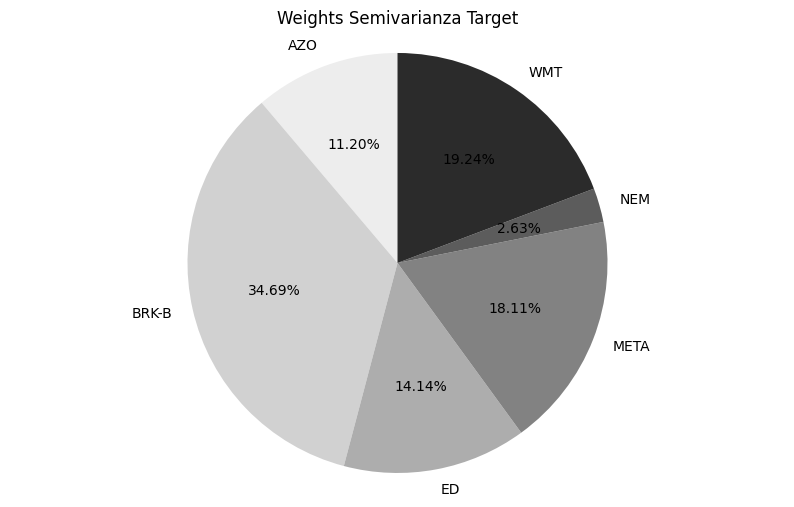

In [122]:
palette = sns.color_palette('Greys', len(w_semivar))

plt.figure(figsize=(10, 6))
plt.pie(
    w_semivar, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Semivarianza Target')
plt.axis('equal')
plt.show()

#### Optimización Máximo de Omega

In [123]:
omega = optimize_port.opt_max_omega(rets_benchmark)*0.5
dict_omega = dict(zip(ret.columns, omega))
dict_omega

{'AZO': 0.02500000000000001,
 'BRK-B': 0.025,
 'ED': 0.025,
 'META': 0.35,
 'NEM': 0.02500000000000002,
 'WMT': 0.05000000000000001}

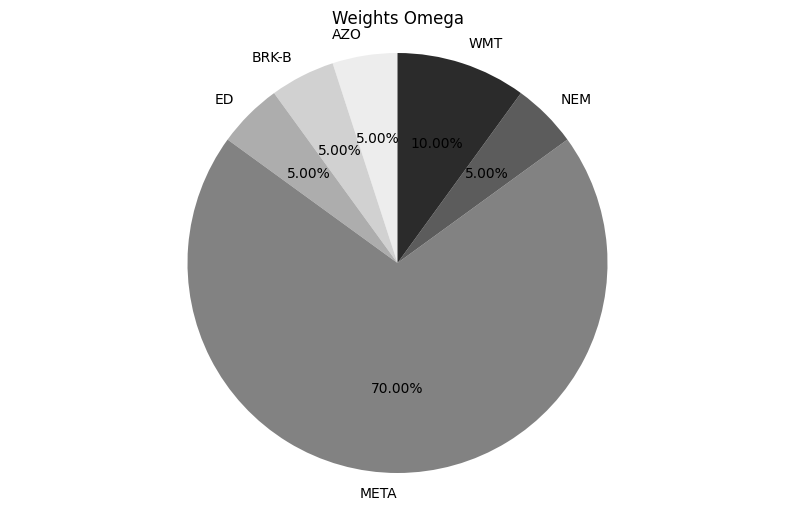

In [124]:
palette = sns.color_palette('Greys', len(omega))

plt.figure(figsize=(10, 6))
plt.pie(
    omega, 
    labels=ret.columns, 
    colors=palette, 
    autopct='%.2f%%', 
    startangle=90
)
plt.title('Weights Omega')
plt.axis('equal')
plt.show()

##### Ponderaciones 

In [125]:
DataFrame_tactical = pd.DataFrame({
    'Mínima Varianza': dict_minvar,
    'Máximo Sharpe': dict_maxsharpe,
    'Mínimo Semivarianza': dict_semivar,
    'Max Omega': dict_omega
})
DataFrame_tactical

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.084211,1.125797e-01,0.055979,0.025
BRK-B,0.108993,5.176296e-19,0.173457,0.025
ED,0.171545,3.370833e-02,0.070684,0.025
META,0.047885,9.468436e-02,0.090539,0.350
NEM,0.012608,3.564886e-02,0.013130,0.025
WMT,0.074759,2.233787e-01,0.096210,0.050


---

## Strategic Asset Allocation

 ### Obtención de Datos


In [126]:
strategic_prices = yf.download(['^TYX', 'IEF'], start='2024-01-01', end='2025-07-01', progress=False)['Close']

In [127]:
returns_strategic = strategic_prices.pct_change().dropna()

### Optimizar portafolio Strategic

In [128]:
optimize_strategic = OptimizePortfolioWeights(returns=returns_strategic, risk_free=0.0445)

#### Optimización Mínima Varianza

In [129]:
w_min_var = optimize_strategic.opt_min_var()*0.5
dict_minvar_strategic = dict(zip(returns_strategic.columns, w_min_var))
dict_minvar_strategic

{'IEF': 0.37396597897912126, '^TYX': 0.1260340210208787}

#### Optimización Máximo de Sharpe

In [130]:
w_max_sharpe = optimize_strategic.opt_max_sharpe()*0.5
dict_maxsharpe_strategic = dict(zip(returns_strategic.columns, w_max_sharpe))
dict_maxsharpe_strategic

{'IEF': 0.35212036900692867, '^TYX': 0.14787963099307133}

#### Optimización Semivarianza Target

In [131]:
w_semivar_strategic = optimize_strategic.opt_min_semivar(rets_benchmark)*0.5
dict_semivar_strategic = dict(zip(returns_strategic.columns, w_semivar_strategic))
dict_semivar_strategic

{'IEF': 0.2749416267502692, '^TYX': 0.22505837324973083}

In [132]:
w_omega = optimize_strategic.opt_max_omega(rets_benchmark)*0.5
dict_omega_strategic = dict(zip(returns_strategic.columns, w_omega))
dict_omega_strategic

{'IEF': 0.15000000000000002, '^TYX': 0.35}

##### Ponderaciones 

In [133]:
DataFrame_strategic = pd.DataFrame({
    'Mínima Varianza': dict_minvar_strategic,
    'Máximo Sharpe': dict_maxsharpe_strategic,
    'Mínimo Semivarianza': dict_semivar_strategic,
    'Max Omega': dict_omega_strategic
})
DataFrame_strategic*100

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
IEF,37.396598,35.212037,27.494163,15.0
^TYX,12.603402,14.787963,22.505837,35.0


---

### Portafolio 

In [134]:
combined_df = DataFrame_tactical.add(DataFrame_strategic, fill_value=0)
combined_df = combined_df.div(combined_df.sum())
Portafolio = combined_df 
Portafolio

,Mínima Varianza,Máximo Sharpe,Mínimo Semivarianza,Max Omega
AZO,0.084211,1.125797e-01,0.055979,0.025
BRK-B,0.108993,5.176296e-19,0.173457,0.025
ED,0.171545,3.370833e-02,0.070684,0.025
IEF,0.373966,3.521204e-01,0.274942,0.150
META,0.047885,9.468436e-02,0.090539,0.350
NEM,0.012608,3.564886e-02,0.013130,0.025
WMT,0.074759,2.233787e-01,0.096210,0.050
^TYX,0.126034,1.478796e-01,0.225058,0.350


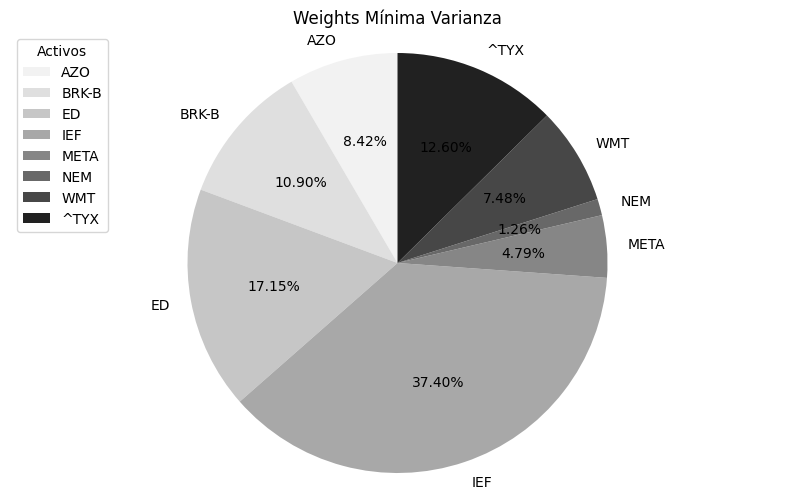

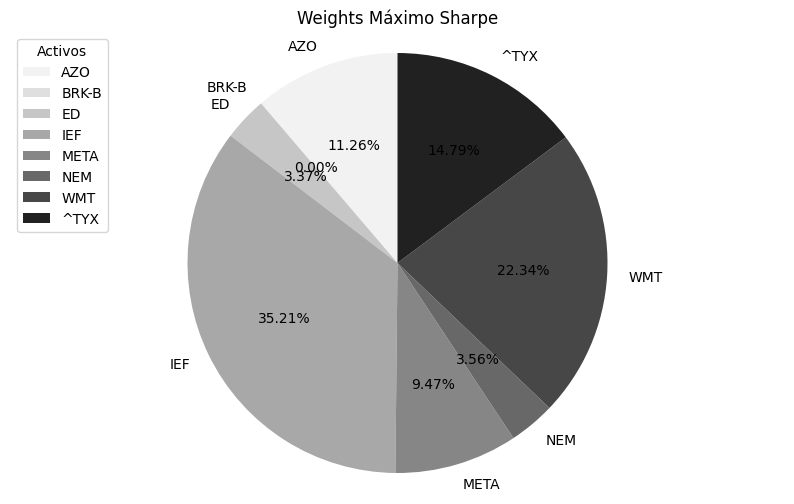

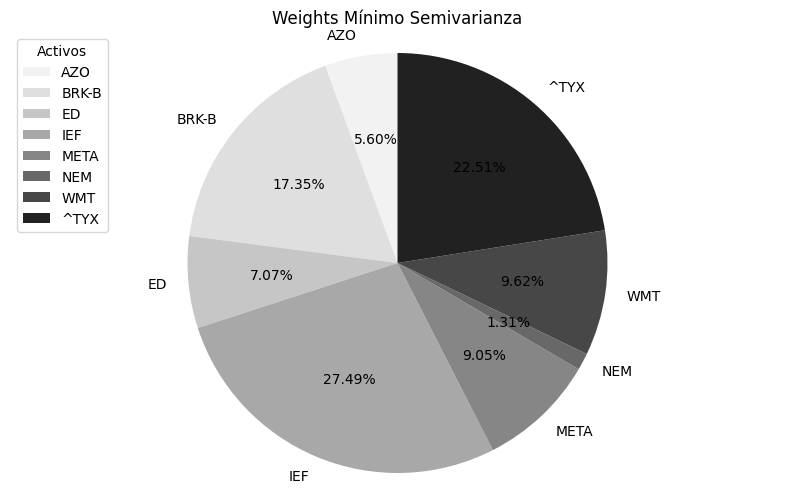

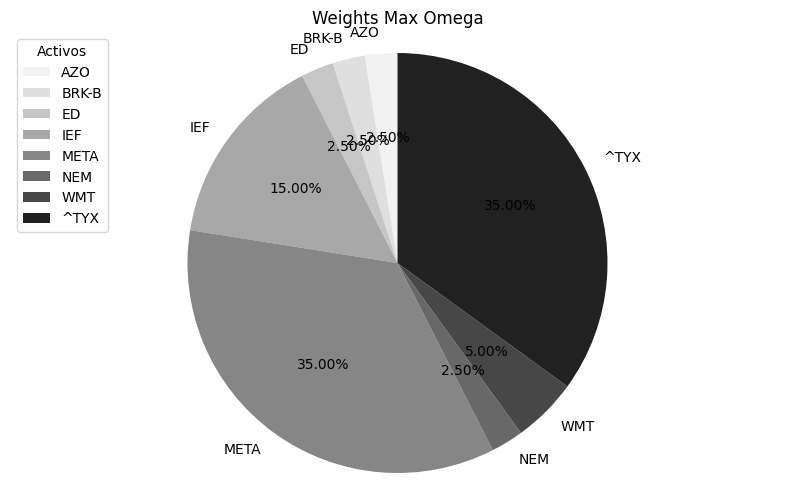

In [135]:
plot_weights_pie(Portafolio, 'Mínima Varianza')
plot_weights_pie(Portafolio, 'Máximo Sharpe')
plot_weights_pie(Portafolio, 'Mínimo Semivarianza')
plot_weights_pie(Portafolio, 'Max Omega')

---

### Backtesting

In [ ]:
history = dynamic_backtesting(
    tickers,            
    strategic_prices,   
    benchmark,          
    capital=1000000,                   
    rf=0.0445,                           
    months=6                             
).simulation()
history

,Min Var,Sharpe,Semivar,Omega,Benchmark
Date,,,,,
2024-07-02,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.005084e+06
2024-07-03,9.962456e+05,9.979159e+05,9.966823e+05,9.981118e+05,1.010561e+06
2024-07-05,1.001594e+06,1.009459e+06,1.003434e+06,1.019133e+06,1.011588e+06
2024-07-08,9.987134e+05,1.005556e+06,1.000475e+06,1.010989e+06,1.012338e+06
2024-07-09,1.001542e+06,1.008384e+06,1.003138e+06,1.013254e+06,1.022672e+06
...,...,...,...,...,...
2025-06-20,1.180028e+06,1.206079e+06,1.191064e+06,1.179960e+06,1.093694e+06
2025-06-23,1.185456e+06,1.215084e+06,1.197768e+06,1.189005e+06,1.105858e+06
2025-06-24,1.182368e+06,1.212082e+06,1.192265e+06,1.186724e+06,1.105854e+06


## Visualización Backtesting

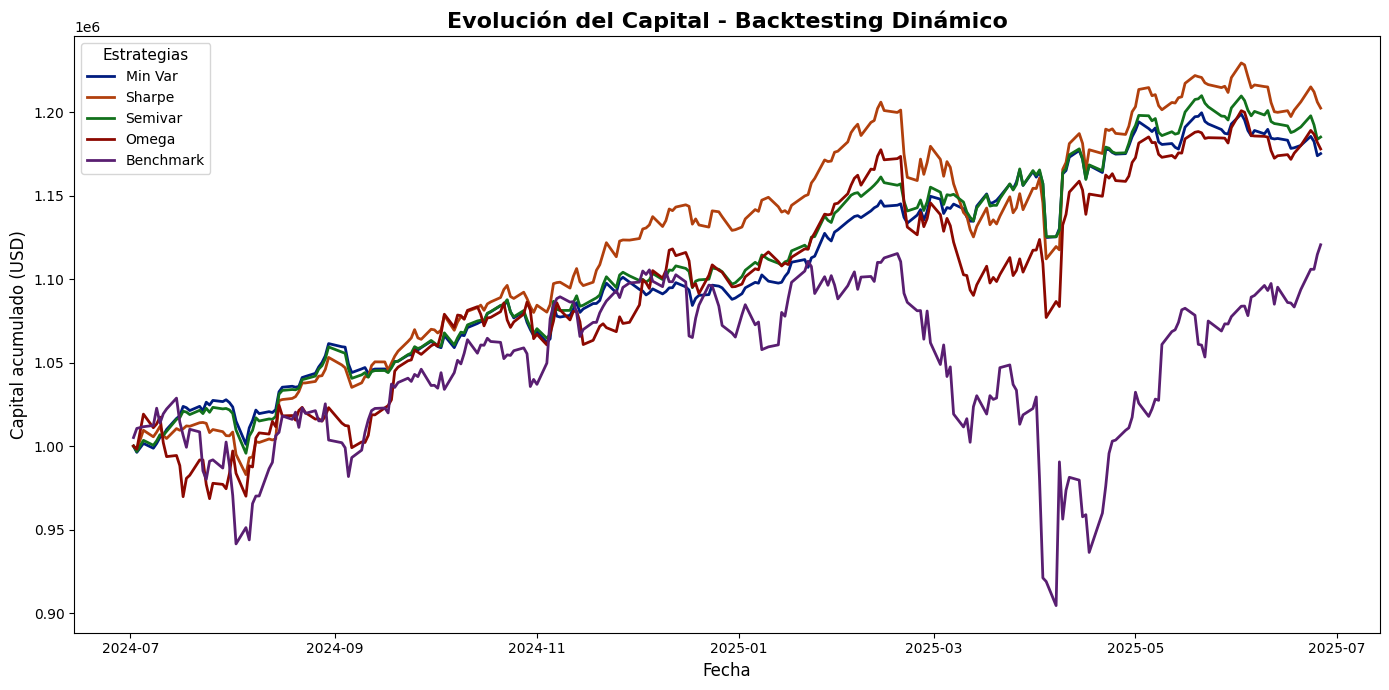

In [137]:
plt.figure(figsize=(14, 7))

colors = sns.color_palette("dark", n_colors=len(history.columns))

for i, col in enumerate(history.columns):
    plt.plot(history.index, history[col], label=col, linewidth=2, color=colors[i])

plt.title('Evolución del Capital - Backtesting Dinámico', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital acumulado (USD)', fontsize=12)

plt.legend(title="Estrategias", loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


### Métricas de Desempeño del Portafolio de Inversión


In [145]:
metrics_table = get_metrics(history, rf=0.0445)
metrics_table

,Min Var,Sharpe,Semivar,Omega,Benchmark
Rend,0.168291,0.193861,0.177125,0.174980,0.131315
Vol,0.076712,0.100314,0.079397,0.120322,0.200532
R Sharpe,1.613711,1.488938,1.670414,1.084423,0.432924
Downside,0.044705,0.057619,0.045274,0.069463,0.123585
Upside,0.049770,0.066520,0.052413,0.077485,0.128785
Omega,1.113294,1.154476,1.157702,1.115482,1.042077
Beta,0.010852,0.000380,0.009765,-0.015805,1.000000
Alpha de Jensen,0.122849,0.149328,0.131778,0.131852,0.000000
R Treynor,11.407665,393.151312,13.582022,-8.255729,0.086815
R Sortino,2.769054,2.592229,2.929413,1.878403,0.702473


---